In [1]:
# Analysis libraries
import numpy as np
import pandas as pd
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
from scipy.special import gamma, hyp2f1
from scipy.stats import ks_2samp, kstest

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.ticker as tck
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import shapely 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd

# Other libraries
import os
import sys
import re
import itertools


# autoreload modules when code is run
%load_ext autoreload
from utils import *

In [2]:
sns.set(font='Avenir', font_scale=1.3, style='ticks')
fig_formats = ['.pdf', '.png', '.svg']
fig_dir = '../fig/'
supfig_dir = fig_dir+'supfig/'
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(supfig_dir, exist_ok=True)
figsize_geo = (10,7.5)

colorSRF = '#7BC8F6'
colorDCM = '#000033'

palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)

golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)

# Preprocessing data

### Metadata

In [3]:
# import metadata

filename_meta = '../data/woa_pisces_tarassd.tsv'
df = pd.read_csv(filename_meta, sep ='\t')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="ESRI:54030")

# station 50 is missing!
# station 19 will be further removed because of bad data
gdf.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn,geometry
129,205,72.4693,-71.8920,SUR,5,10,584.5,-0.89261,31.219290,1.793274,0.440587,3.355274,107.994,0.848,1.990,1.035,POINT (-71.892 72.469)
130,206,70.9618,-53.6030,SUR,5,10,564.5,2.43763,32.896900,1.785118,0.084252,2.914919,-999.000,-999.000,-999.000,-999.000,POINT (-53.603 70.962)
131,208,69.1136,-51.5086,SUR,5,10,508.0,2.93860,33.131413,1.630793,0.000000,3.127574,-999.000,-999.000,-999.000,-999.000,POINT (-51.509 69.114)
132,209,64.7127,-53.0106,SUR,5,10,531.5,2.51751,32.442013,3.216127,0.491307,0.668157,90.334,0.996,2.416,1.333,POINT (-53.011 64.713)
133,210,61.5442,-55.9865,SUR,5,10,535.0,5.20301,33.989799,3.419286,0.553510,2.276372,61.584,1.006,0.427,1.519,POINT (-55.986 61.544)


### Abundance data

In [4]:
# import abundances

filename_abund = '../data/Abundance.csv'
Abundances = pd.read_csv(filename_abund, index_col=0, header=0)
# since the column 019_SRF has a total abundance of 3, we remove it both from Abundances and gdf
Abundances = Abundances.drop(columns=['019_SRF'])
gdf = gdf.loc[~gdf['station'].isin([19])]
Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

 Number of stations: 124 
 Number of different OTUs: 5830

 Number of stations SRF: 124 
 Number of stations DCM: 58


### Entropies and Regions

In [5]:
# add entropy measures to metadata

for depth in Depths:
    gdf['station_{}'.format(depth)] = gdf['station'].apply(lambda x: '{0:s}_{1:s}'.format(str(x).zfill(3),depth) if '{}_{}'.format(str(x).zfill(3), depth) in Abundances.columns else np.nan) 
    gdf['TotAbundance_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: Abundances[x].sum(axis=0) if x in Abundances.columns else None)
    gdf['Richness_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: len(Abundances.loc[Abundances[x]>0]) if x in Abundances.columns else None)
    gdf['Shannon_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: entropy(Normalized_Abundances.loc[:,x]) if x in Abundances.columns else None)
    gdf['Evenness_{}'.format(depth)] = gdf['Shannon_{}'.format(depth)]/np.log(gdf['Richness_{}'.format(depth)])
    
# add regions to metadata
gdf['region'] = gdf['latitude'].apply(lambda x : return_geo(x))



### Preliminary fits

We load the fits obtained by fitting Equation 1 of the paper to the data. Equation 1 reads:
$$
P(n) = \theta\left(\alpha,\beta, r \right) \frac{\Gamma (\beta +1) \Gamma (n+\alpha )}{\Gamma (\alpha ) \Gamma (n+\beta +1)} e^{-r n}
$$

where we have introduced the parameters $\alpha=\chi/b$, $\beta=\mu/d$, and $r=\log{b/d}$, whilst $\Gamma(\cdot)$ is the Gamma function and $\theta\left(\alpha,\beta, r \right)$ is a normalization factor that ensures $\sum_{n\geq1}P(n)=1$. 

In [6]:
# import fits

filename_fits = '../data/fit_completi.csv'
fits = pd.read_csv(filename_fits, index_col=0)

# rename columns
fits = fits.rename(columns={'vec_estimated_k':'beta', 'vec_estimated_l':'alpha', 'vec_estimated_r':'r'})#.reset_index(inplace=True)
fits['station_number'] = fits['station'].apply(lambda x: int(x.split('_')[0]))
fits['lambda'] = 1 - fits.loc[:,'alpha'] + fits.loc[:,'beta']
fits = fits.set_index('station')

# add fits to metadata
for depth in Depths:
    gdf['lambda_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'lambda'] if x in fits.index else None)
    gdf['alpha_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'alpha'] if x in fits.index else None)
    gdf['beta_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'beta'] if x in fits.index else None)
    gdf['r_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fits.loc[x,'r'] if x in fits.index else None)
    # station 50 is missing!
    
# remove stations with no fit (where r is not nan)
SRF = gdf[gdf['r_SRF'].notna()]
DCM = gdf[gdf['r_DCM'].notna()]
# remove lambda_DCM	alpha_DCM	beta_DCM	r_DCM from SRF and viceversa
SRF = SRF.drop(columns=['lambda_DCM','alpha_DCM','beta_DCM','r_DCM', 'station_DCM', 'TotAbundance_DCM',	'Richness_DCM',	'Shannon_DCM',	'Evenness_DCM'])
DCM = DCM.drop(columns=['lambda_SRF','alpha_SRF','beta_SRF','r_SRF', 'station_SRF', 'TotAbundance_SRF',	'Richness_SRF',	'Shannon_SRF',	'Evenness_SRF'])
    
print('Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(SRF),len(DCM)))
print('Number of stations with r=0 SRF: {} \n Number of stations with r=0 DCM: {}'.format(len(SRF[SRF['r_SRF']==0]),len(DCM[DCM['r_DCM']==0])))


Number of stations SRF: 123 
 Number of stations DCM: 58
Number of stations with r=0 SRF: 96 
 Number of stations with r=0 DCM: 34


### Power law fits

In [7]:
# power law fit to data

lambda_dict, pval_dict = {}, {}
for col in Abundances.columns:
    data = Abundances[col].values
    station = col
    rho, pvalue = maximum_likelihood_exponent(data)
    lambda_dict[station] = rho + 1
    pval_dict[station] = pvalue

# add power law fits to metadata
SRF['lambda_PL'] = SRF['station_SRF'].apply(lambda x: lambda_dict[x] if x in lambda_dict.keys() else None)
DCM['lambda_PL'] = DCM['station_DCM'].apply(lambda x: lambda_dict[x] if x in lambda_dict.keys() else None)

## Undersampling

### From power law fits
If the metacommunity SAD follows a power law, then the local SADs follow a power law as well. In particular, we suppose that the metacommunity SADs follow a power law with exponent $\rho_j$:
$$
P(n) = \frac{1}{\zeta (\rho +1)} n^{-1-\rho}
$$

We exploit the limit $p\to0$, where $p$ is the sampling effort, to obtain a relation between the sample richness $S_{loc}$ and abundance $N_{loc}$ with the total richness $S$ and abundance $N$ of the metacommunity. This relation reads:
$$
S_{loc} = \underbrace{-\frac{\Gamma (-\rho )}{\zeta (\rho +1)} \frac{S}{(N)^{\rho}}}_{K} N_{loc}^{\rho}
$$
We want to test the hypothesis that all the local SADs are sampled from the same meta-community. This means that $K$ and $\rho$ the same for all the local SADs. We can test this hypothesis by choosing a  station as a reference station and predict the richness of the other stations. We can then compare the predicted richness with the observed richness:
$$
S_{loc} = S_{ref} \left(\frac{N_{loc}}{N_{ref}}\right)^{\rho}
$$

$\rho$ is the exponent of the metacommunity. Here, several options are possible:
1. We can use the exponent of the reference station as the exponent of the metacommunity.
2. We can use the average or the median of the exponents of all the stations as the exponent of the metacommunity.
3. We can use the mode of the exponents of all the stations as the exponent of the metacommunity.

In [43]:
# rho should be the exponent of the metacommunity.
which = 'mode' # it can be either the reference station (173_SRF), the mode, the mean, the median.
ref_station = 173

if which == '173_SRF':
    rho_PL = SRF.loc[SRF['station_SRF']==which,'lambda_PL'].values[0] - 1
elif which == 'mode':
    rho_PL = mode_with_binning(SRF['lambda_PL'], bins=5) - 1
elif which == 'mean':
    rho_PL = np.round(SRF['lambda_PL'].mean() - 1, 2)
elif which == 'median':
    rho_PL = np.round(SRF['lambda_PL'].median() - 1, 2)
else:
    print('Error: which should be either 173_SRF, mode, mean or median')

print('rho = {}'.format(rho_PL))

N_ref, S_ref = SRF.loc[SRF['station']==ref_station,['TotAbundance_SRF', 'Richness_SRF']].values[0]
print('N_ref = {}, S_ref = {}'.format(N_ref, S_ref))
SRF['Spred_PL'] = SRF.loc[:,'TotAbundance_SRF'].apply(lambda N_loc: (N_loc/N_ref)**(rho_PL)*S_ref)
SRF['DeltaS_PL'] = (SRF['Spred_PL'] - SRF['Richness_SRF'])/SRF['Richness_SRF']
SRF['pval_PL'] = SRF.loc[:,['Richness_SRF', 'Spred_PL']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_PL'] = DCM.loc[:,'TotAbundance_DCM'].apply(lambda N_loc: (N_loc/N_ref)**(rho_PL)*S_ref)
DCM['DeltaS_PL'] = (DCM['Spred_PL'] - DCM['Richness_DCM'])/DCM['Richness_DCM']
DCM['pval_PL'] = DCM.loc[:,['Richness_DCM', 'Spred_PL']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_PL < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_PL < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_PL']<0.05])/len(SRF)*100, len(DCM[DCM['pval_PL']<0.05])/len(DCM)*100))

rho = 0.5344101870311722
N_ref = 312215.0, S_ref = 422.0
Percentage of stations with pval_PL < 0.05 SRF: 90.24 
Percentage of stations with pval_PL < 0.05 DCM: 96.55


### From asymptotic behaviour of original fits

We follow the same procedure outlined for the power law fits. We use the asymptotic behaviour of the original fits to predict the richness of the local SADs. The asymptotic behaviour of the original fits is given by the same equaiton, where now $\rho=\lambda-1$ is the asymptotic exponent of the original fits. Since $\rho$ is the exponent of the metacommunity, we have several options:
1. We can use the exponent of the reference station as the exponent of the metacommunity.
2. We can use the average or the median of the exponents of all the stations as the exponent of the metacommunity.
3. We can use the mode of the exponents of all the stations as the exponent of the metacommunity. The mode is defined after a binning procedure. We bin the exponents in bins of width 0.1 and we take the mode of each bin.

In [42]:
# rho should be the exponent of the metacommunity.
which = 'mode' # it can be either the reference station (173_SRF), the mode, the mean, the median.
ref_station = 173

if which == '173_SRF':
    rho_asympt = SRF.loc[SRF['station']==ref_station,'lambda_SRF'].values[0] - 1
elif which == 'mode':
    rho_asympt = mode_with_binning(SRF['lambda_SRF'], bins=5) - 1
elif which == 'mean':
    rho_asympt = np.round(SRF['lambda_SRF'].mean() - 1, 2)
elif which == 'median':
    rho_asympt = np.round(SRF['lambda_SRF'].median() - 1, 2)
else:
    print('Error: which should be either 173_SRF, mode, mean or median')

print('rho = {}'.format(rho_asympt))

N_ref, S_ref = SRF.loc[SRF['station']==ref_station,['TotAbundance_SRF', 'Richness_SRF']].values[0]
print('N_ref = {}, S_ref = {}'.format(N_ref, S_ref))
SRF['Spred_asympt'] = SRF.loc[:,'TotAbundance_SRF'].apply(lambda N_loc: (N_loc/N_ref)**(rho_asympt)*S_ref)
SRF['DeltaS_asympt'] = (SRF['Spred_asympt'] - SRF['Richness_SRF'])/SRF['Richness_SRF']
SRF['pval_asympt'] = SRF.loc[:,['Richness_SRF', 'Spred_asympt']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_asympt'] = DCM.loc[:,'TotAbundance_DCM'].apply(lambda N_loc: (N_loc/N_ref)**(rho_asympt)*S_ref)
DCM['DeltaS_asympt'] = (DCM['Spred_asympt'] - DCM['Richness_DCM'])/DCM['Richness_DCM']
DCM['pval_asympt'] = DCM.loc[:,['Richness_DCM', 'Spred_asympt']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_asympt < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_asympt < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_asympt']<0.05])/len(SRF)*100, len(DCM[DCM['pval_asympt']<0.05])/len(DCM)*100))

rho = 0.5085233951414954
N_ref = 312215.0, S_ref = 422.0
Percentage of stations with pval_asympt < 0.05 SRF: 88.62 
Percentage of stations with pval_asympt < 0.05 DCM: 94.83


### From original fits

In [41]:
filename_originalDS = '../data/Sloc_Spred_173_SRF_BHM.csv'
dfS = pd.read_csv(filename_originalDS, index_col=0)
dfS['DeltaS']=(dfS['Spred']-dfS['Sobs'])/dfS['Sobs']

# splitting the dataset in two (SRF and DCM)
dfS_SRF = dfS.loc[[st for st in dfS.index if st[-3:] == 'SRF'],:]
dfS_DCM = dfS.loc[ [st for st in dfS.index if st[-3:] == 'DCM'],:]

# adding Spred to SRF and DCM metadata
SRF['Spred_original'] = SRF['station'].apply(lambda x: dfS_SRF.loc['{:03}_SRF'.format(x),'Spred'])
SRF['DeltaS_original'] = SRF['station'].apply(lambda x: dfS_SRF.loc['{:03}_SRF'.format(x),'DeltaS'])
SRF['pval_original'] = SRF.loc[:,['Richness_SRF', 'Spred_original']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

DCM['Spred_original'] = DCM['station'].apply(lambda x: dfS_DCM.loc['{:03}_DCM'.format(x),'Spred'])
DCM['DeltaS_original'] = DCM['station'].apply(lambda x: dfS_DCM.loc['{:03}_DCM'.format(x),'DeltaS'])
DCM['pval_original'] = DCM.loc[:,['Richness_DCM', 'Spred_original']].apply(lambda x: two_tailed_pvalue(x[0], x[1], np.sqrt(x[1])), axis=1)

print('Percentage of stations with pval_original < 0.05 SRF: {0:1.2f} \nPercentage of stations with pval_original < 0.05 DCM: {1:1.2f}'.format(len(SRF[SRF['pval_original']<0.05])/len(SRF)*100, len(DCM[DCM['pval_original']<0.05])/len(DCM)*100))

dfS_SRF.head()

Percentage of stations with pval_original < 0.05 SRF: 73.98 
Percentage of stations with pval_original < 0.05 DCM: 84.48


,Sobs,Spred,DeltaS
station,,,
158_SRF,47,54,0.148936
188_SRF,516,608,0.178295
194_SRF,319,348,0.090909
206_SRF,300,447,0.490000
191_SRF,245,366,0.493878


In [27]:
len(SRF[SRF['pval_original']<0.01])/len(SRF)

0.6422764227642277

# Analysis and results

## 1. SADs and synthetic sampling experiment

### SRF and DCM SADs

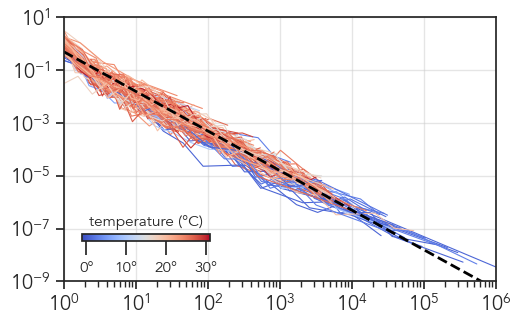

In [67]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

# SRF stations
for station in SRF.station.values[::-1]:
    col = '{:03}_SRF'.format(station)
    data = Abundances[col].values
    # log histogram
    bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    color = palette[colorindex]
    x = bins[:-1]
    x = x[pdf>0]
    y = pdf[pdf>0]
    sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.8, ls='-', alpha=1, zorder=1)
    
# DCm stations
for station in DCM.station.values[::-1]:
    col = '{:03}_DCM'.format(station)
    data = Abundances[col].values
    # log histogram
    bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    color = palette[colorindex]
    x = bins[:-1]
    x = x[pdf>0]
    y = pdf[pdf>0]
    sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.8, ls='-', alpha=1, zorder=1)
        
cax = fig.add_axes([0.15, 0.25, 0.25, 0.025])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')

# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1a_SAD_all_collapsed' + fig_format, dpi=300)

### Mock SADs by multinomial sampling from a reference SAD

In [68]:
reference_station_name = '173_SRF'
data = Abundances[reference_station_name].values
data = data[data>0]

total_abundance = np.sum(data)
print('Total abundance: {}'.format(total_abundance))
print('Number of OTUs: {}'.format(len(data)))

# generate a vector of probabilities for each OTU. The probability of each OTU is proportional to its abundance.
probabilities = data/total_abundance

sampling_efforts, richnesses_observed, multisamples, richnesses, colors, temperatures = [], [], [], [], [], []

# SRF stations
for station in SRF.station.values[::-1]:
    col = '{:03}_SRF'.format(station)
    sampling_efforts.append(np.sum(Abundances[col].values))
    richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
    multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
    richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    temperatures.append(tempereature)
    colors.append(palette[colorindex])
    
# DCM stations
for station in DCM.station.values[::-1]:
    col = '{:03}_DCM'.format(station)
    sampling_efforts.append(np.sum(Abundances[col].values))
    richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
    multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
    richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
    colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
    temperatures.append(tempereature)
    colors.append(palette[colorindex])

Total abundance: 312215
Number of OTUs: 422


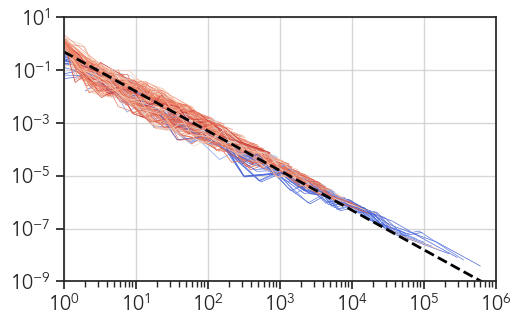

In [69]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

for i, sample in enumerate(multisamples):
    sample = sample[sample>0]
    bins, counts, prob, pdf = log_hist(sample, nbins=20)
    x = bins[:-1]
    y = pdf
    x = x[y>0]
    y = y[y>0]
    sns.lineplot(x=x, y=y, ax=ax, lw=.5, ls='-', alpha=1, zorder=1, color=colors[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.8, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
# sohw legend on the right
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')
# don't show legend
#ax.legend().set_visible(False)



# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1b_SAD_multisample' + fig_format, dpi=300)

### Richness comparison

NameError: name 'richnesses_observed' is not defined

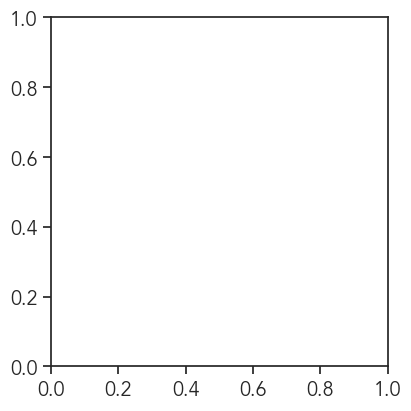

In [44]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

x = np.array (richnesses_observed)
y = np.array(richnesses)
max_y = np.max(y)
print(max_y)
y = y[x<=max_y]
cs = np.array(colors)[x<=max_y]
x = x[x<=max_y]

# calculate correlation coefficient and p-value between observed and synthetic richnesses
r, p = pearsonr(x, y)
print('Pearson correlation coefficient: {}'.format(r))
print('r^2: {}'.format(r**2))
print('p-value: {}'.format(p))


sns.scatterplot(x=x, y=y, ax=ax, s=50, color=cs, alpha=1, zorder=1, lw=0.1, edgecolor='black')

ax.set_xlabel('empirical', loc='right', font='Avenir', fontsize=16)
ax.set_ylabel('synthetic', loc='top', font='Avenir', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(5*1e0, 1e3)
ax.set_ylim(5*1e0, 1e3)

# write text "RICHNESS"
ax.text(0.3, 0.85, 'RICHNESS', transform=ax.transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

'''
cax = fig.add_axes([0.275, 0.85, 0.25, 0.02])
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=10)
cbar.ax.set_title('temperature (°C)', font='Avenir')
# change size of the colorbar title
cbar.ax.title.set_fontsize(12)
'''

# draw a 1:1 line
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

for fig_format in fig_formats:
    fig.savefig(fig_dir + 'fig1c_richness' + fig_format, dpi=300)

## Power law fits

### Histograms of the power law exponents

Text(0.5, 0.98, 'PL')

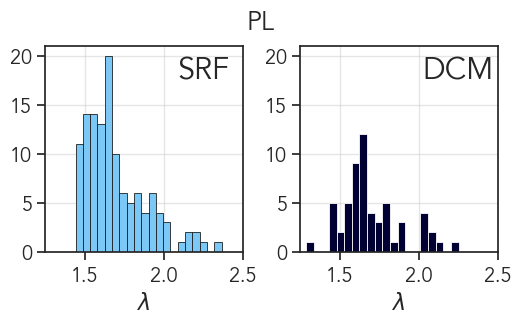

In [134]:
fig, axes = plt.subplots(1,2, figsize=figsize, constrained_layout=True)

sns.histplot(x='lambda_PL', data=SRF, ax=axes[0], bins=20, stat='count', edgecolor='k', lw=1, color=colorSRF, alpha=1, zorder=1)
sns.histplot(x='lambda_PL', data=DCM, ax=axes[1], bins=20, stat='count', edgecolor='w', lw=1, color=colorDCM, alpha=1, zorder=1)

axes[0].text(0.8, 0.8, 'SRF', transform=axes[0].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')
axes[1].text(0.8, 0.8, 'DCM', transform=axes[1].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

for ax in axes:
    ax.set_xlabel(r'$\lambda$', font='Avenir', fontsize=16)
    ax.set_ylabel('', font='Avenir', fontsize=16)
    ax.set_xlim(1.25, 2.5)
    ax.set_ylim(0, 21)
    ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
    
fig.suptitle('PL')

Text(0.5, 0.98, 'ES')

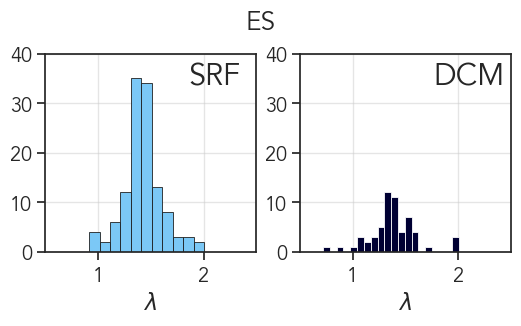

In [135]:
fig, axes = plt.subplots(1,2, figsize=figsize, constrained_layout=True)

sns.histplot(x='lambda_SRF', data=SRF, ax=axes[0], bins=20, stat='count', edgecolor='k', lw=1, color=colorSRF, alpha=1, zorder=1, label='SRF')
sns.histplot(x='lambda_DCM', data=DCM, ax=axes[1], bins=20, stat='count', edgecolor='w', lw=1, color=colorDCM, alpha=1, zorder=1)

axes[0].text(0.8, 0.8, 'SRF', transform=axes[0].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')
axes[1].text(0.8, 0.8, 'DCM', transform=axes[1].transAxes, font='Avenir', fontsize=22, fontweight='bold', ha='center', va='bottom')

for ax in axes:
    ax.set_xlabel(r'$\lambda$', font='Avenir', fontsize=16)
    ax.set_ylabel('', font='Avenir', fontsize=16)
    ax.set_xlim(.5, 2.5)
    ax.set_ylim(0, 40)
    ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
    
fig.suptitle('ES')

Total abundance: 312215
lambda PL: 1.654193201801047
lambda fit: 1.485529379081201


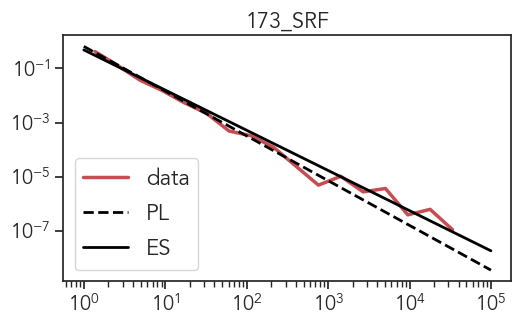

In [138]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
ax.set_xscale('log')
ax.set_yscale('log')

station = '173_SRF'
ax.set_title(station)

data = Abundances[station].values
print('Total abundance: {}'.format(np.sum(data)))
print('lambda PL: {}'.format(lambda_dict['173_SRF']))
print('lambda fit: {}'.format(fits.loc['173_SRF','lambda']))

bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
x = np.sqrt(bins[:-1]*bins[1:])
y = pdf
x = x[y>0]
y = y[y>0]
sns.lineplot(x=x, y=y, ax=ax, lw=2.5, ls='-', alpha=1, zorder=1, color='r', label='data')

# power law fit plot
x = np.logspace(0, 5, 100)
alpha_pl = lambda_dict[station]-1
y = alpha_pl * x**(-alpha_pl-1)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1, label='PL')

# Bruno fit
x = np.logspace(0, 5, 100)
lambda_SRF = fits.loc[station,'lambda']-1
y = lambda_SRF * x**(-lambda_SRF-1)
sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='-', alpha=1, zorder=1, label='ES')

ax.legend(fontsize=16, loc='lower left')




## Downscaling

### Comparison of the results of the different methods

mode 0.5344101870311722 0.5085233951414954


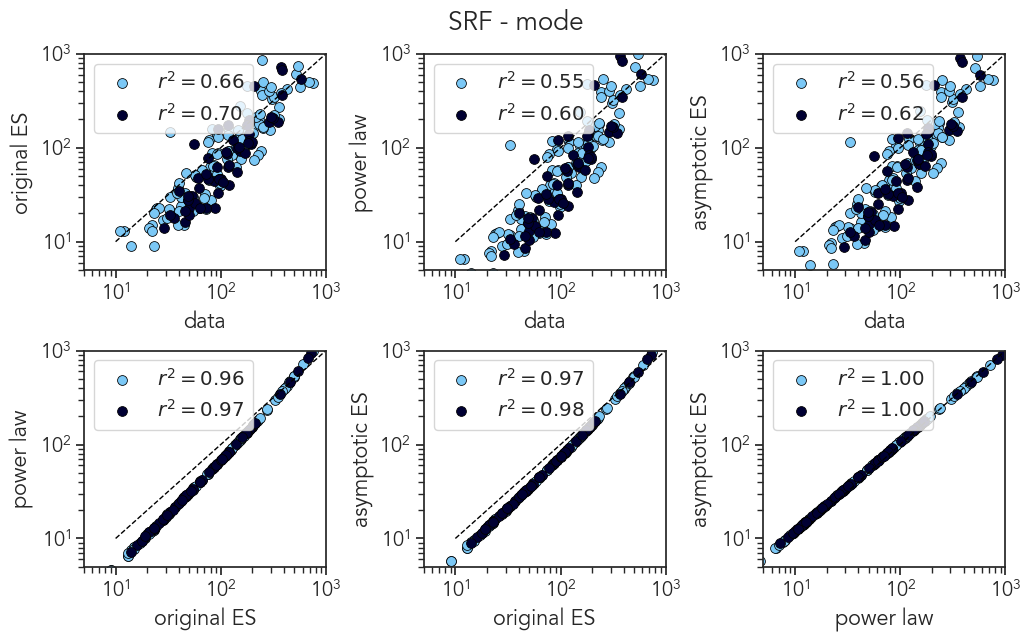

In [95]:
print(which, rho_PL, rho_asympt)

cols = ['Richness_SRF', 'Spred_original', 'Spred_PL', 'Spred_asympt']

def return_name(col):
    if 'original' in col:
        return 'original ES'
    elif 'PL' in col:
        return 'power law'
    elif 'asympt' in col:
        return 'asymptotic ES'
    elif 'Richness' in col:
        return 'data'
    else:
        return None

fig, axes = plt.subplots(2, 3, figsize=(figsize[0]*2, figsize[1]*2), constrained_layout=True)
fig.suptitle('SRF - {}'.format(which))

for i, (col1, col2) in enumerate(itertools.combinations(cols, 2)):
    ax = axes.flatten()[i]
    ax.set_xscale('log') 
    ax.set_yscale('log')
    ax.set_xlim(5*1e0, 1e3)
    ax.set_ylim(5*1e0, 1e3)
    ax.set_xlabel(return_name(col1))
    ax.set_ylabel(return_name(col2))
    r, p = pearsonr(SRF[col1], SRF[col2])
    #print('{} - {}: r = {}, p = {}'.format(col1, col2, r, p))
    sns.scatterplot(x=SRF[col1], y=SRF[col2], ax=ax, label=r'$r^2={:.2f}$'.format(r**2), s=50, color=colorSRF, alpha=1, zorder=1, lw=0.1, edgecolor='black')
    if col1 == 'Richness_SRF':
        col1 = 'Richness_DCM'
    if col2 == 'Richness_SRF':
        col2 = 'Richness_DCM'
    r, p = pearsonr(DCM[col1], DCM[col2])
    sns.scatterplot(x=DCM[col1], y=DCM[col2], ax=ax, s=50, label=r'$r^2={:.2f}$'.format(r**2), color=colorDCM, alpha=1, zorder=1, lw=0.1, edgecolor='black')
    
    # draw a 1:1 line
    ax.plot([1e1, 1e3], [1e1, 1e3], color='black', lw=1, ls='--', alpha=1, zorder=1)

plt.show()

for fig_format in fig_formats:
    fig.savefig(supfig_dir + 'Spred_comparison_{}'.format(which) + fig_format, dpi=300)

### Power law fits

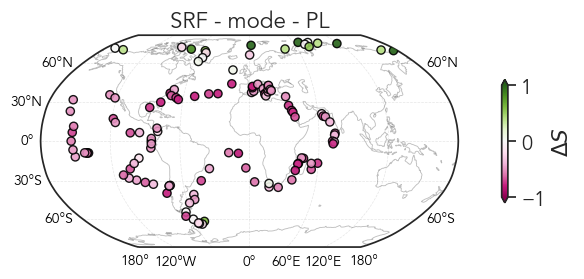

In [96]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_PL"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })

ax.set_title('SRF - {} - PL'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(supfig_dir + 'DeltaS_{}_SRF_PL'.format(which) + fig_format, dpi=300)

### Asymptotic behavior of fits

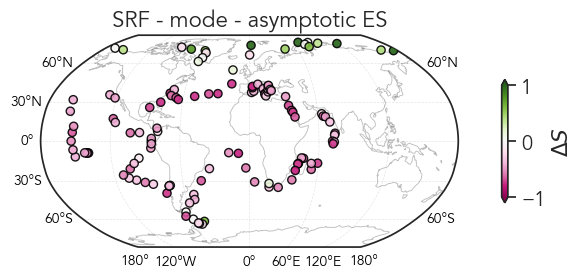

In [97]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_asympt"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })


ax.set_title('SRF - {} - asymptotic ES'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(supfig_dir + 'DeltaS_{}_SRF_asympt'.format(which) + fig_format, dpi=300)

### Original downscaling

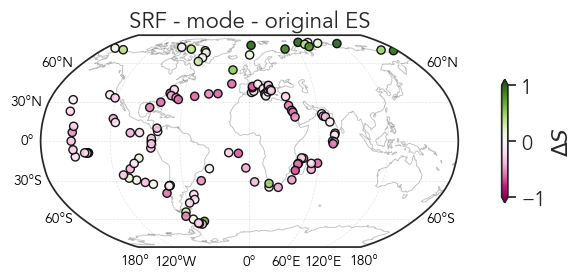

In [98]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
ax.set_global()
#ax.stock_img()
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_original"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = SRF.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })


ax.set_title('SRF - {} - original ES'.format(which), font='Avenir', fontsize=16)
for fig_format in fig_formats:
        fig.savefig(supfig_dir + 'DeltaS_{}_SRF_original'.format(which) + fig_format, dpi=300)

In [99]:
dfS_SRF.loc['158_SRF','Spred']

54

In [ ]:
# mock sads obtained by sampling from the observed distribution

reference_station_name = '173_SRF'
data = Abundances[reference_station_name].values
data = data[data>0]

total_abundance = np.sum(data)
print('Total abundance: {}'.format(total_abundance))
print('Number of OTUs: {}'.format(len(data)))

# generate a vector of probabilities for each OTU. The probability of each OTU is proportional to its abundance.
probabilities = data/total_abundance

sampling_efforts = []
richnesses_observed = []
multisamples = []
richnesses = []
colors = []
temperatures = []

for station in SRF.station.values:
    

for col in Abundances.columns:
    station = int(col.split('_')[0])
    if ((station != 50) and (np.sum(Abundances[col].values) >= 100)):
        sampling_efforts.append(np.sum(Abundances[col].values))
        richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
        multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
        richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
        colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        temperatures.append(tempereature)
        colors.append(palette[colorindex])
